In [1]:
from agents.matchmanager import MatchManager,buildMatchManager
from itertools import product
from agents import GreedyAgent, AlphaBetaAgent, RandomAgent
from scenarios import scenarioJunction, scenarioJunctionExo, scenarioTest1v1, scenarioTest2v2
from core.const import RED, BLUE
from agents.ml.simple import SimpleMLAgent
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
import random
from sklearn.ensemble import ExtraTreesClassifier


In [8]:
dfs=[]
for i in range(1):
    board, state = scenarioJunction()
    playerRed = SimpleMLAgent(RED, {'scenario': board.name, 'model': 'RandomForestClassifier'})
    playerBlue = SimpleMLAgent(BLUE, {'scenario': board.name, 'model': 'RandomForestClassifier'})
    mm = MatchManager(' ', playerRed, playerBlue, board, state, seed=514)
    while not mm.end:
        mm.nextStep()
    dfs.append(playerBlue.createDf(i))
    dfs.append(playerRed.createDf(i))
df=pd.concat(dfs)

C:\Users\Nicol\Documents\Master\SecondoProgetto\newtechnowar-webui\code\agents\ml\simple.py:46: RuntimeWarning: invalid value encountered in true_divide
  return -(norm * np.log(norm) / np.log(len(scores))).sum()
C:\Users\Nicol\Documents\Master\SecondoProgetto\newtechnowar-webui\code\agents\ml\simple.py:46: RuntimeWarning: invalid value encountered in true_divide
  return -(norm * np.log(norm) / np.log(len(scores))).sum()
C:\Users\Nicol\Documents\Master\SecondoProgetto\newtechnowar-webui\code\agents\ml\simple.py:46: RuntimeWarning: invalid value encountered in true_divide
  return -(norm * np.log(norm) / np.log(len(scores))).sum()
C:\Users\Nicol\Documents\Master\SecondoProgetto\newtechnowar-webui\code\agents\ml\simple.py:46: RuntimeWarning: invalid value encountered in true_divide
  return -(norm * np.log(norm) / np.log(len(scores))).sum()
C:\Users\Nicol\Documents\Master\SecondoProgetto\newtechnowar-webui\code\agents\ml\simple.py:46: RuntimeWarning: invalid value encountered in true_di

In [9]:
df

,Agente,Probabilità,Mossa,Entropia,Mosse disponibili,RandomChoice,SceltaRandom,Count,Numero Partita
0,blue,0.290104,BLUE : Pass in response,1.000000,3,False,0,0,0
1,blue,0.353944,BLUE : bInf1 : Attack rInf3 with Mortar,0.988711,179,False,0,1,0
2,blue,0.228769,BLUE : bInf2 : Attack rInf3 with Mortar in...,0.996770,4,False,0,2,0
3,blue,0.321599,"BLUE : bInf2 : Moved to (39, 30)",0.999752,145,False,0,3,0
4,blue,0.377746,BLUE : bAPC1 : Attack rInf3 with Machine gun,0.999988,112,False,0,4,0
5,blue,0.453260,BLUE : Pass in response,1.000000,2,False,0,5,0
6,blue,0.623630,"BLUE : bInf1 : Moved to (35, 31)",0.999340,68,False,0,6,0
7,blue,0.134347,BLUE : Pass in response,NaN,1,False,0,7,0
8,blue,0.243720,"BLUE : bInf2 : Moved to (37, 28)",0.999077,36,False,0,8,0
9,blue,0.625630,BLUE : bInf1 : Attack rTank3 with Anti-tan...,0.987774,2,False,0,9,0


# Traiettoria probabilità

In [ ]:
boxplot=df.boxplot(column=['Probabilità', 'Entropia'],by='Agente')

In [ ]:
boxplot=df.boxplot(column=['Probabilità', 'Entropia'],by='Numero Partita')

In [ ]:
boxplot=df.boxplot(column=['Probabilità', 'Entropia'],by=['Numero Partita','Agente'])

In [ ]:
boxplot=df[df['Numero Partita']==0].boxplot(column=['Entropia'],by=['Agente'])

In [ ]:
df

In [ ]:
df['index']=df.index

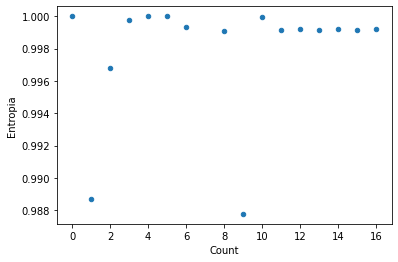

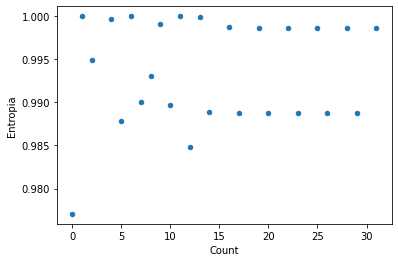

In [10]:
plot=df.groupby('Agente').plot.scatter(x='Count',y='Entropia')

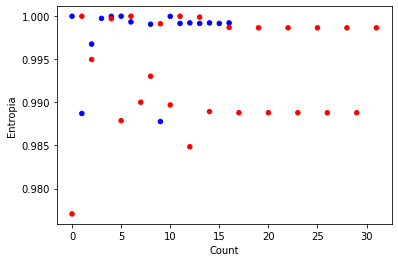

In [11]:
plot=df.plot.scatter(x='Count',y='Entropia',c='Agente')

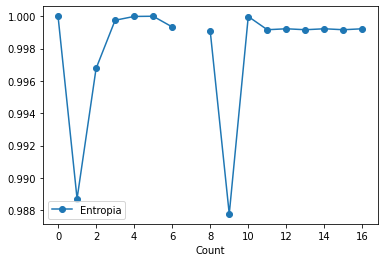

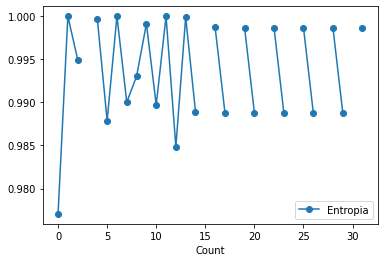

In [15]:
plot=df.groupby('Agente').plot.line(x='Count',y='Entropia',style='-o')

# Analisi features dataframe

In [16]:
def random_forest(df):
    f_select=[]
   
    X = df.drop('winner',1)
    y = df['winner'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = RandomForestClassifier(n_estimators=100)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    proba = np.around(proba, decimals=2)


    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    # feature importanti per determinarlo
    feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Feature importance:\n', feature_imp)
    f_selection=feature_imp[(feature_imp>0.005)]
    print('Feature selection:\n',f_selection)
            
        
    # Creating a bar plot
    sns.barplot(x=f_selection, y=f_selection.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()
    #return X_test, y_test, y_pred, proba


In [ ]:
def feature_importance(df):
    X = df.drop('winner',1)
    y = df['winner'].values    

    model = ExtraTreesClassifier()
    model.fit(X,y)
    #print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

In [ ]:
def selectfrommodel(df):
    X = df.drop('winner',1)
    y = df['winner'].values

    feature_names = X.columns
    #print(feature_names)
    clf = LassoCV().fit(X, y)
    importance = np.abs(clf.coef_)
    #print(importance)
    idx_third = importance.argsort()[-3]
    threshold = importance[idx_third] + 0.01

    idx_features = (-importance).argsort()[:5]
    name_features = np.array(feature_names)[idx_features]
    print('Selected features: {}'.format(name_features))


[[ 802   48]
 [  25 1302]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       850
           1       0.96      0.98      0.97      1327

    accuracy                           0.97      2177
   macro avg       0.97      0.96      0.96      2177
weighted avg       0.97      0.97      0.97      2177

Accuracy: 0.9664676159853008
Feature importance:
 meta_seed             0.055048
positionZ_blue_1_2    0.052347
positionY_blue_1_1    0.049979
positionY_blue_1_2    0.049716
positionZ_blue_1_1    0.047082
                        ...   
bonus_blue_2_0        0.000000
hp_max_blue_2_0       0.000000
load_blue_2_0         0.000000
move_blue_2_0         0.000000
team_red_2_0          0.000000
Length: 244, dtype: float64
Feature selection:
 meta_seed              0.055048
positionZ_blue_1_2     0.052347
positionY_blue_1_1     0.049979
positionY_blue_1_2     0.049716
positionZ_blue_1_1     0.047082
positionX_blue_1_2     0.046519
positionY_blue_

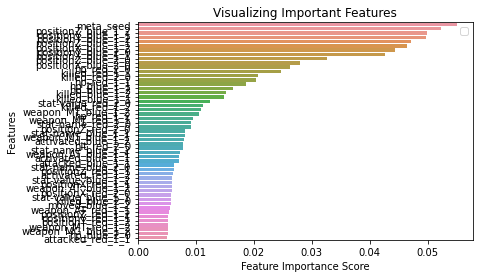

[[429  20]
 [ 13 558]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       449
           1       0.97      0.98      0.97       571

    accuracy                           0.97      1020
   macro avg       0.97      0.97      0.97      1020
weighted avg       0.97      0.97      0.97      1020

Accuracy: 0.9676470588235294
Feature importance:
 positionY_blue_2_0             0.074175
positionZ_blue_1_2             0.057979
meta_seed                      0.055354
positionY_blue_1_2             0.053457
positionY_blue_1_1             0.046705
                                 ...   
transported-by_blue_2_0        0.000000
len-transporting_blue_2_0      0.000000
transport-capacity_blue_2_0    0.000000
can-transport_blue_2_0         0.000000
team_red_2_0                   0.000000
Length: 244, dtype: float64
Feature selection:
 positionY_blue_2_0     0.074175
positionZ_blue_1_2     0.057979
meta_seed              0.055354
positionY_blue_1

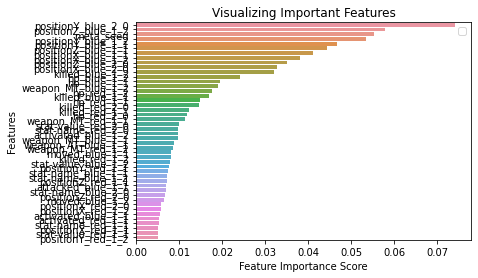

In [17]:
dataframes = {"Junction": "../../data.scenarioJunction.pkl.gz",
              "JunctionExo": "../../data.scenarioJunctionExo.pkl.gz",
              "Test1v1": "../../../data.2020-11-09.scenarioTest1v1.pkl.gz",
              "Test2v2": "../../../data.2020-11-09.scenarioTest2v2.pkl.gz"}
pilots = ["Junction", "JunctionExo"]

for p in pilots:
    df = pd.read_pickle(dataframes[p])
    df = df.loc[((df.meta_p_red == "GreedyAgent") & (df.meta_p_blue == "GreedyAgent"))]
    c=df.select_dtypes(include='object').columns.tolist()
    le = preprocessing.LabelEncoder()
    df[c] = df[c].apply(lambda col: le.fit_transform(col))
    random_forest(df)

In [ ]:
from core import GM
from core.actions import Action
from core.game.board import GameBoard
from core.game.state import GameState
from agents import Agent, GreedyAgent
import numpy as np
from core.const import RED, BLUE
import pandas as pd
import os.path as op

import joblib

In [ ]:
vectors=[]
v = list(createDf(bs,ba,scores))
vectors.append(v)



cols = list(createDf_info()) 

df = pd.DataFrame(data=vectors, columns=cols)


In [ ]:
bs,ba=bestAction(scores)

In [ ]:
model=joblib.load('C:\\Users\\Nicol\\Documents\\Master\\SecondoProgetto\\newtechnowar-webui\\code\\models\\Junction_RandomForestClassifier.joblib')

In [ ]:
scores=[]
for figure in state.getFiguresCanBeActivated(BLUE):
    actions = [GM.actionPassFigure(figure)] + \
              GM.buildAttacks(board, state, figure) + \
              GM.buildMovements(board, state, figure)
    for action in actions:
        newState, outcome = GM.activate(board, state, action)

        X = np.array(newState.vector()).reshape(1, -1)
        cols = newState.vectorInfo()
        df = pd.DataFrame(data=X, columns=cols)
        score = model.predict_proba(df)

        scores.append((score, action))

In [ ]:
scores

In [ ]:
    def bestAction(scores: list) :
        bestScore, bestAction = 0.0, None

        for probs, action in scores:
            if (BLUE):
                #print("ok")
                score = probs[0, 0]
            else:
                #print("no")
                score = probs[0, 1]
            if score >= bestScore:
                bestScore, bestAction = score, action

        return bestScore,bestAction

In [ ]:
import random

In [ ]:
    def bestActionRandom(scores: list) -> Action:
        bestScore,bestAction = 0.0,None
        if (len(scores) != 0):
            sorted_multi_list = sorted(scores, key=lambda x: x[0][0][0])
            # questo sorted mi occupa moooolto tempo, si può fare altro modo?
            if (BLUE):
                choice=random.choice(sorted_multi_list[-10:])
                bestScore=choice[0][0][0]
                bestAction = choice[1]
            else:
                choice = random.choice(sorted_multi_list[:10])
                bestScore = choice[0][0][1]
                bestAction = choice[1]
        return bestScore,bestAction
        
    

In [ ]:
    def entropy2(scores: list, prob):
        probs = takeProbs(scores)
        normprobs = prob / sum(probs)
        return -(normprobs * np.log(normprobs) / np.log(len(scores)))
    #ritorna valore di entropia della sola probabilità che passo

In [ ]:
    def createDf_info():
        info=["Agente","Probabilità","Mossa","Entropia","Mosse disponibili"]
        return tuple(info)

In [ ]:
    def createDf(bestscore,bestaction,scores):

        data=["BLUE",bestscore,bestaction,entropy2(scores,bestscore),len(scores)]
        return tuple(data)

In [ ]:
bestScore, bestAction = 0.0, None
#print(sorted(scores, reverse=True))

for probs, action in scores:
    print(probs)
    if (BLUE):
        score = probs[0, 0]
        print("ehi",score)
        print(action)
    else:
        score = probs[0, 1]
        print(score)
    if score >= bestScore:
        bestScore, bestAction = score, action

In [ ]:
for probs, action in scores:
    print(probs[0]) 

In [ ]:
    probabilieties=[]
    for probs, action in scores:
        probabilieties.append(probs[0])  
    arr=np.array(probabilieties)
    blue_prob=arr[:,0]
    norm = [float(i)/sum(blue_prob) for i in blue_prob]
    -(norm*np.log(norm)/np.log(len(scores)))


In [ ]:
arr[:,1]

In [ ]:
entropy1(scores)

In [ ]:
    def takeProbs(scores: list):
        probabilieties = []
        if (BLUE):
            i = 0
        else:
            i = 1
        for probs, action in scores:
            probabilieties.append(probs[0])
        arr = np.array(probabilieties)
        return arr[:, i]

    def entropy1(scores: list):
        probs = takeProbs(scores)
        norm = [float(i) / sum(probs) for i in probs]
        return -(norm * np.log(norm) / np.log(len(scores)))

In [ ]:
entropy1(scores)

In [ ]:
    def entropy2(scores: list, prob):
        probs = takeProbs(scores)
        print(probs)
        normprobs = prob / sum(probs)
        return -(normprobs * np.log(normprobs) / np.log(len(scores)))

In [ ]:
entropy2(scores,probs[0][0])